# Importing The Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Loading The Dataset

In [2]:
categories = ['sci.med', 'comp.graphics']
newsgroups = fetch_20newsgroups(subset='all', categories=categories,
                                remove=('headers', 'footers', 'quotes'), random_state=42)

In [3]:
df = pd.DataFrame({
    'text': newsgroups.data,
    'target': newsgroups.target,
    'category': [categories[i] for i in newsgroups.target]
})

In [4]:
print(f"Dataset shape: {df.shape}")
print(f"Category distribution:\n{df['category'].value_counts()}")

Dataset shape: (1963, 3)
Category distribution:
category
comp.graphics    990
sci.med          973
Name: count, dtype: int64


# Displaying Sample Data

In [5]:
print("\nSample texts from each category:")
for category in categories:
    sample_text = df[df['category'] == category]['text'].iloc[0][:200] + "..."
    print(f"\n{category}: {sample_text}")


Sample texts from each category:

sci.med: Hi all,

  I am looking for a recommandation on a good royalty free graphics
library package for C and C++ program.  This is mainly use to write
children games and education software.  I heard someone...

comp.graphics: 
You certainly do not see OTC preparations advertised as such.
The only such ridiculous concoctions are nostrums for premenstrual
syndrome, ostensibly to treat headache and "bloating" simultaneously.
...


# Text Preprocessing

Text Cleaning

In [6]:
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [7]:
df['cleaned_text'] = df['text'].apply(clean_text)

Removing Frequent Words (Custom Stopwords)

In [8]:
def get_frequent_words(texts, n=50):
    all_words = ' '.join(texts).split()
    word_freq = Counter(all_words)
    return [word for word, freq in word_freq.most_common(n)]

In [9]:
frequent_words = get_frequent_words(df['cleaned_text'].tolist(), 30)
custom_stopwords = set(frequent_words)

print(f"Custom stopwords (top 10): {list(custom_stopwords)[:10]}")

Custom stopwords (top 10): ['that', 'of', 'is', 'by', 'in', 'to', 'with', 'and', 'can', 'it']


Removing Stopwords

In [10]:
def remove_stopwords(text, stop_words):
    if not isinstance(text, str):
        return ""

    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

In [11]:
df['processed_text'] = df['cleaned_text'].apply(
    lambda x: remove_stopwords(x, custom_stopwords)
)

# Displaying Cleaned and Original Text

In [12]:
print("\nOriginal vs Cleaned Text Comparison:")
sample_idx = 10
print(f"\nOriginal text:\n{df['text'].iloc[sample_idx][:150]}...")
print(f"\nCleaned text:\n{df['processed_text'].iloc[sample_idx][:150]}...")


Original vs Cleaned Text Comparison:

Original text:

And to add further fuel to the flame war, I read about 20 years ago that
the "natural" MSG - extracted from the sources you mention above - does not
...

Cleaned text:
add further fuel flame war read about years ago natural msg extracted sources mention above does cause reported aftereffects its only nasty artificial...


# Splitting The Dataset

In [13]:
X = df['processed_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1374
Test set size: 589


# Model Training and Evaluation

In [14]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    cm = confusion_matrix(y_test, y_pred)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': y_pred
    }

In [15]:
vectorizers = {
    'CountVectorizer': CountVectorizer(max_features=5000, min_df=2, max_df=0.8),
    'TfidfVectorizer': TfidfVectorizer(max_features=5000, min_df=2, max_df=0.8),
    'BinCountVectorizer': CountVectorizer(max_features=5000, min_df=2, max_df=0.8, binary=True)
}
results = []
trained_models = {}
alpha_values = [0.1, 0.5, 1, 5, 10]

Multinomial Naive Bayes with Different Vectorizers and Alpha Values

In [16]:
for vec_name, vectorizer in vectorizers.items():
    if 'Bin' not in vec_name:  # Skip binary for Multinomial (use for Bernoulli)
        for alpha in alpha_values:
            pipeline = Pipeline([
                ('vectorizer', vectorizer),
                ('classifier', MultinomialNB(alpha=alpha))
            ])

            pipeline.fit(X_train, y_train)

            result = evaluate_model(pipeline, X_test, y_test,
                                  f"MNB_{vec_name[0:6]}_alpha{alpha}")
            results.append(result)
            trained_models[result['model_name']] = pipeline

            print(f"{result['model_name']}: Accuracy = {result['accuracy']:.4f}, F1 = {result['f1_score']:.4f}")

MNB_CountV_alpha0.1: Accuracy = 0.9338, F1 = 0.9337
MNB_CountV_alpha0.5: Accuracy = 0.9321, F1 = 0.9320
MNB_CountV_alpha1: Accuracy = 0.9287, F1 = 0.9286
MNB_CountV_alpha5: Accuracy = 0.9236, F1 = 0.9235
MNB_CountV_alpha10: Accuracy = 0.9202, F1 = 0.9201
MNB_TfidfV_alpha0.1: Accuracy = 0.9423, F1 = 0.9423
MNB_TfidfV_alpha0.5: Accuracy = 0.9287, F1 = 0.9287
MNB_TfidfV_alpha1: Accuracy = 0.9185, F1 = 0.9185
MNB_TfidfV_alpha5: Accuracy = 0.8998, F1 = 0.8998
MNB_TfidfV_alpha10: Accuracy = 0.8930, F1 = 0.8929


Bernoulli Naive Bayes with Binary Vectorizer

In [17]:
for alpha in alpha_values:
    pipeline = Pipeline([
        ('vectorizer', vectorizers['BinCountVectorizer']),
        ('classifier', BernoulliNB(alpha=alpha))
    ])

    pipeline.fit(X_train, y_train)
    result = evaluate_model(pipeline, X_test, y_test,
                          f"BNB_binary_alpha{alpha}")
    results.append(result)
    trained_models[result['model_name']] = pipeline

    print(f"{result['model_name']}: Accuracy = {result['accuracy']:.4f}, F1 = {result['f1_score']:.4f}")

BNB_binary_alpha0.1: Accuracy = 0.9032, F1 = 0.9027
BNB_binary_alpha0.5: Accuracy = 0.8829, F1 = 0.8818
BNB_binary_alpha1: Accuracy = 0.8761, F1 = 0.8747
BNB_binary_alpha5: Accuracy = 0.8217, F1 = 0.8176
BNB_binary_alpha10: Accuracy = 0.7963, F1 = 0.7900


# Performance Analysis

In [18]:
results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Accuracy': r['accuracy'],
    'F1_Score': r['f1_score'],
    'Vectorizer': 'Count' if 'Count' in r['model_name'] else 'Tfidf' if 'Tfidf' in r['model_name'] else 'Binary',
    'Classifier': 'Multinomial' if 'Multinomial' in r['model_name'] else 'Bernoulli',
    'Alpha': float(r['model_name'].split('alpha')[-1])
} for r in results])

print("Model Performance Summary: \n")
print(results_df.round(4).sort_values(by= ['F1_Score', 'Accuracy'], ascending=False).to_string(index=False))

Model Performance Summary: 

              Model  Accuracy  F1_Score Vectorizer Classifier  Alpha
MNB_TfidfV_alpha0.1    0.9423    0.9423      Tfidf  Bernoulli    0.1
MNB_CountV_alpha0.1    0.9338    0.9337      Count  Bernoulli    0.1
MNB_CountV_alpha0.5    0.9321    0.9320      Count  Bernoulli    0.5
MNB_TfidfV_alpha0.5    0.9287    0.9287      Tfidf  Bernoulli    0.5
  MNB_CountV_alpha1    0.9287    0.9286      Count  Bernoulli    1.0
  MNB_CountV_alpha5    0.9236    0.9235      Count  Bernoulli    5.0
 MNB_CountV_alpha10    0.9202    0.9201      Count  Bernoulli   10.0
  MNB_TfidfV_alpha1    0.9185    0.9185      Tfidf  Bernoulli    1.0
BNB_binary_alpha0.1    0.9032    0.9027     Binary  Bernoulli    0.1
  MNB_TfidfV_alpha5    0.8998    0.8998      Tfidf  Bernoulli    5.0
 MNB_TfidfV_alpha10    0.8930    0.8929      Tfidf  Bernoulli   10.0
BNB_binary_alpha0.5    0.8829    0.8818     Binary  Bernoulli    0.5
  BNB_binary_alpha1    0.8761    0.8747     Binary  Bernoulli    1.0
  BNB

# Visualizations (Comparisons + Alpha Parameter Impact)

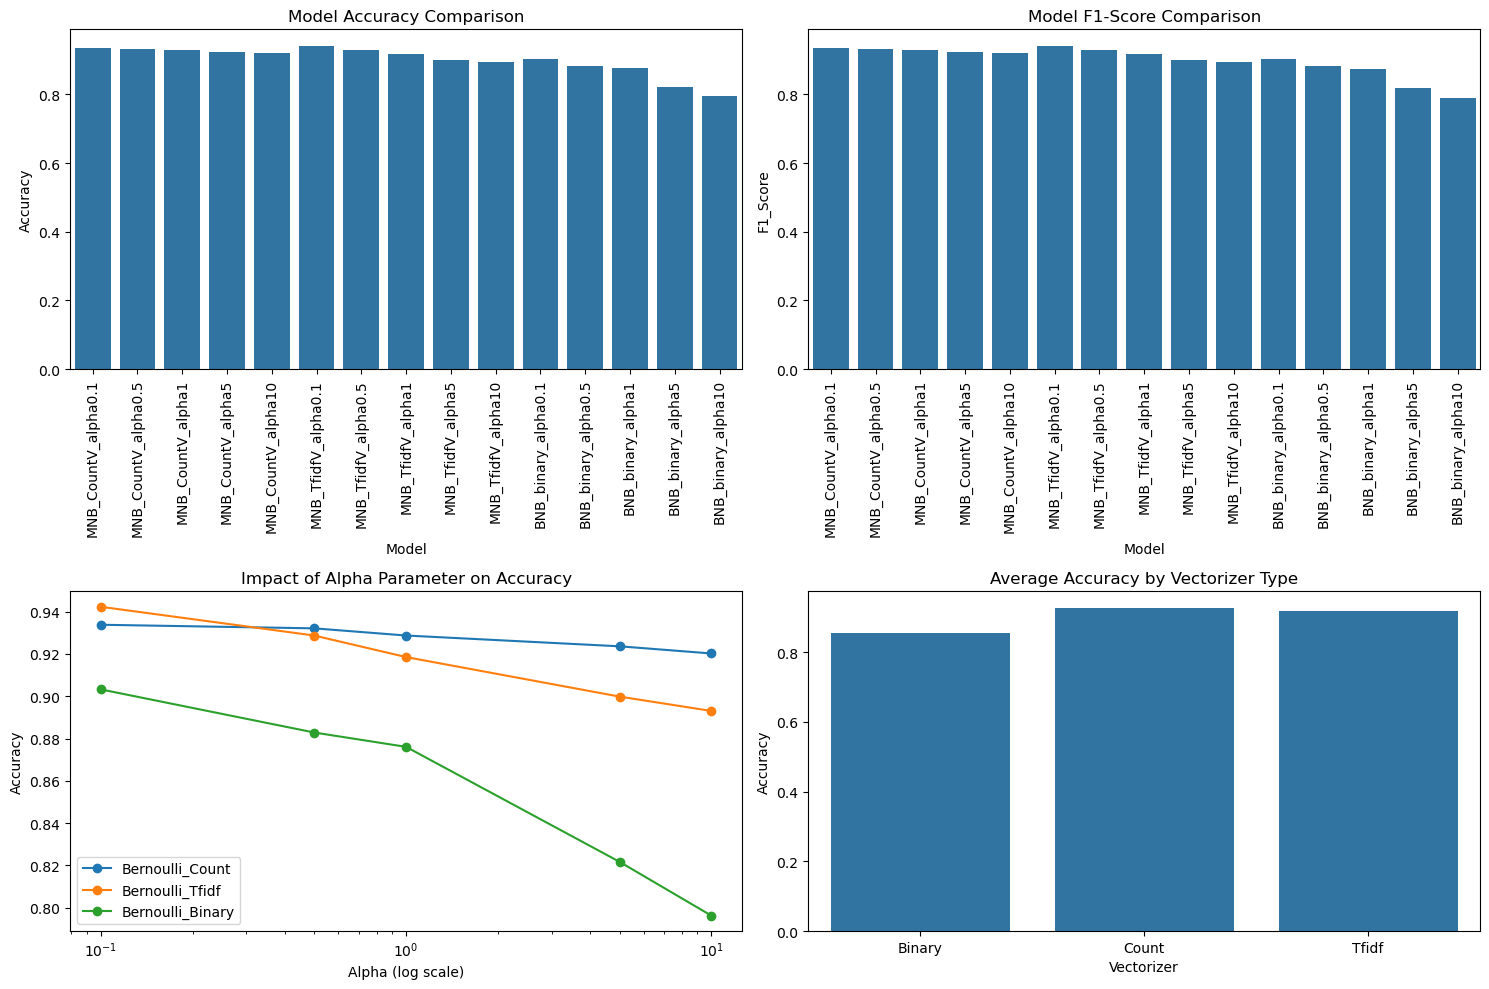

In [19]:
plt.figure(figsize=(15, 10))

# Accuracy comparison
plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=90)


# F1-score comparison
plt.subplot(2, 2, 2)
sns.barplot(data=results_df, x='Model', y='F1_Score')
plt.title('Model F1-Score Comparison')
plt.xticks(rotation=90)


# Alpha parameter impact
plt.subplot(2, 2, 3)
for classifier in results_df['Classifier'].unique():
    for vectorizer in results_df['Vectorizer'].unique():
        subset = results_df[(results_df['Classifier'] == classifier) &
                           (results_df['Vectorizer'] == vectorizer)]
        if len(subset) > 0:
            plt.plot(subset['Alpha'], subset['Accuracy'],
                    marker='o', label=f'{classifier}_{vectorizer}')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Accuracy')
plt.title('Impact of Alpha Parameter on Accuracy')
plt.legend()

# Vectorizer comparison
plt.subplot(2, 2, 4)
vectorizer_comparison = results_df.groupby('Vectorizer')['Accuracy'].mean().reset_index()
sns.barplot(data=vectorizer_comparison, x='Vectorizer', y='Accuracy')
plt.title('Average Accuracy by Vectorizer Type')

plt.tight_layout()
plt.show()

# Confusion Matrices for Best Performing Models

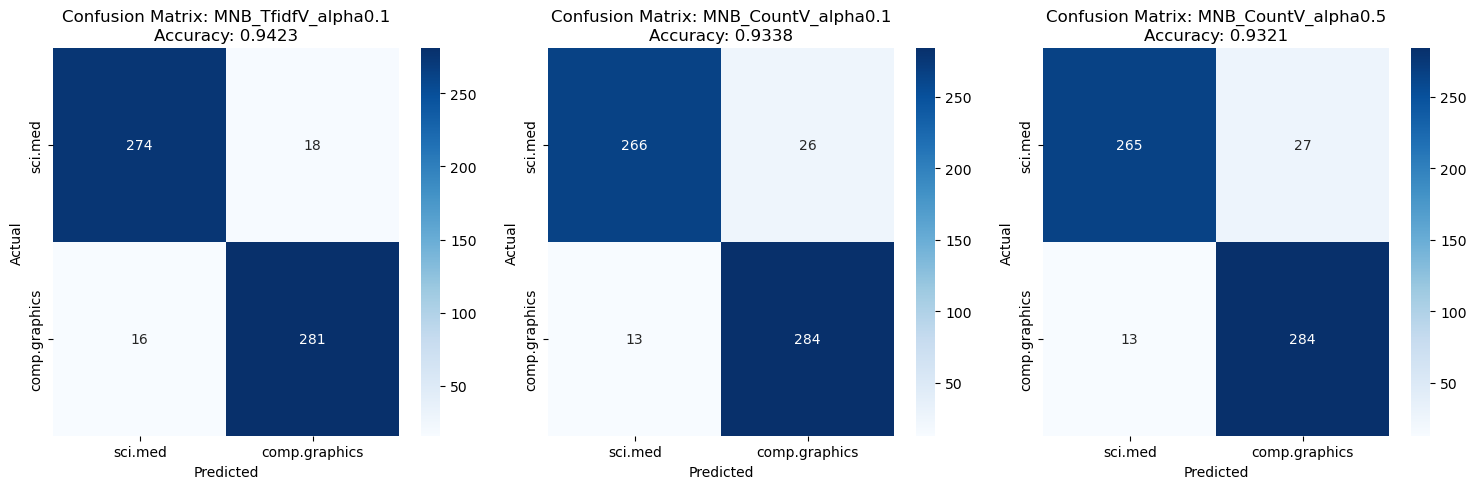

In [20]:
best_models = results_df.nlargest(3, 'Accuracy')['Model'].tolist()

plt.figure(figsize=(15, 5))
for i, model_name in enumerate(best_models, 1):
    plt.subplot(1, 3, i)
    result = next(r for r in results if r['model_name'] == model_name)
    cm = result['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title(f'Confusion Matrix: {model_name}\nAccuracy: {result["accuracy"]:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Error Analysis for Best Model

In [21]:
best_model_name = results_df.nlargest(1, 'Accuracy')['Model'].iloc[0]
best_model = trained_models[best_model_name]

y_pred_best = best_model.predict(X_test)

misclassified_idx = np.where(y_pred_best != y_test)[0]

print(f"Model Name: {best_model_name}")
print(f"Total misclassified: {len(misclassified_idx)}")
print(f"Error rate: {len(misclassified_idx)/len(y_test):.4f}")

Model Name: MNB_TfidfV_alpha0.1
Total misclassified: 34
Error rate: 0.0577


# Displaying Some Misclassified Examples

In [22]:
print("\nSample Misclassified Examples from Best Model:")
for i, idx in enumerate(misclassified_idx[2:7]):
    actual = categories[y_test.iloc[idx]]
    predicted = categories[y_pred_best[idx]]
    text_sample = X_test.iloc[idx][:120] + "..."

    print(f"\nExample {i+1}:")
    print(f"Actual: {actual}, Predicted: {predicted}")
    print(f"Text sample: {text_sample}")


Sample Misclassified Examples from Best Model:

Example 1:
Actual: comp.graphics, Predicted: sci.med
Text sample: nonsteroid proventil brand albuterol bronchodilator regards...

Example 2:
Actual: comp.graphics, Predicted: sci.med
Text sample: dear netters am sure whether right place post my query thought there may some bilingual physicians newsgroup could help ...

Example 3:
Actual: sci.med, Predicted: comp.graphics
Text sample: yes shouldnt size newsgroup issue sorry has been covered before compgrahpicsanimation get how much traffic per day artic...

Example 4:
Actual: comp.graphics, Predicted: sci.med
Text sample: wondering group called scipharmacology would relevent would used more formal discussion about pharmacological issues pha...

Example 5:
Actual: comp.graphics, Predicted: sci.med
Text sample: dear news readers there anyone using sheep models cardiac research specifically concerned arrhythmias pacing defibrillat...


# Detailed Classification Report for Best Model

In [23]:
best_model_predictions = trained_models[best_model_name].predict(X_test)
print(classification_report(y_test, best_model_predictions,
                          target_names=categories))

               precision    recall  f1-score   support

      sci.med       0.94      0.94      0.94       292
comp.graphics       0.94      0.95      0.94       297

     accuracy                           0.94       589
    macro avg       0.94      0.94      0.94       589
 weighted avg       0.94      0.94      0.94       589

